In [49]:
%matplotlib inline
from pandas import read_csv, DataFrame, get_dummies, Series
from numpy import nanmean
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count
from functools import partial
from scipy import stats
from sklearn.preprocessing import normalize
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
# from boruta import BorutaPy
import xgboost as xgb
from random import sample
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, matthews_corrcoef, roc_auc_score, confusion_matrix
from sklearn.metrics import make_scorer, log_loss
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFE, SelectFromModel, SelectKBest, VarianceThreshold
from sklearn.feature_selection import SelectFpr, chi2, mutual_info_classif

In [50]:
from warnings import simplefilter
simplefilter("ignore")

In [51]:
# Train data
data = read_csv("train.csv")

# Test data
test = read_csv("test.csv")
test = test.loc[:, 'feat_1':'feat_93']

In [52]:
data.head(2)

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
0,1,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,Class_1
1,2,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Class_1


### Modifying target from "Class_1" to "1"

In [53]:
data['target'] = data['target'].apply(lambda x: int(x.split('_')[1]))
# Drop the "ID" column
train = data.drop('id', axis=1)

In [54]:
X = train.loc[:, :'feat_93']
y = train['target']
print(X.head(2))

   feat_1  feat_2  feat_3  feat_4  feat_5  feat_6  feat_7  feat_8  feat_9  \
0       1       0       0       0       0       0       0       0       0   
1       0       0       0       0       0       0       0       1       0   

   feat_10   ...     feat_84  feat_85  feat_86  feat_87  feat_88  feat_89  \
0        0   ...           0        1        0        0        0        0   
1        0   ...           0        0        0        0        0        0   

   feat_90  feat_91  feat_92  feat_93  
0        0        0        0        0  
1        0        0        0        0  

[2 rows x 93 columns]


### Normalization

In [16]:
# Normalization of Train and Test
cols = list(X.columns.values)

# Train
X = DataFrame(normalize(X))
X.columns = cols
X.head(2)

# Test
test_xgb_org = DataFrame(normalize(test_xgb_org))
test_xgb_org.columns = cols
test_xgb_org.head(2)

NameError: name 'test_xgb_org' is not defined

In [55]:
# Splitting Train test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=12)

In [57]:
y_test.head()

26781    4
44888    6
60049    9
56633    8
34223    6
Name: target, dtype: int64

# Data Exploration and prepocessing

In [ ]:
# Check for duplicate rows

In [58]:
print('Target Class\n', train['target'].value_counts())

Target Class
 2    16122
6    14135
8     8464
3     8004
9     4955
7     2839
5     2739
4     2691
1     1929
Name: target, dtype: int64


In [59]:
# Missing value check
X_train.isnull().sum()

feat_1     0
feat_2     0
feat_3     0
feat_4     0
feat_5     0
feat_6     0
feat_7     0
feat_8     0
feat_9     0
feat_10    0
feat_11    0
feat_12    0
feat_13    0
feat_14    0
feat_15    0
feat_16    0
feat_17    0
feat_18    0
feat_19    0
feat_20    0
feat_21    0
feat_22    0
feat_23    0
feat_24    0
feat_25    0
feat_26    0
feat_27    0
feat_28    0
feat_29    0
feat_30    0
          ..
feat_64    0
feat_65    0
feat_66    0
feat_67    0
feat_68    0
feat_69    0
feat_70    0
feat_71    0
feat_72    0
feat_73    0
feat_74    0
feat_75    0
feat_76    0
feat_77    0
feat_78    0
feat_79    0
feat_80    0
feat_81    0
feat_82    0
feat_83    0
feat_84    0
feat_85    0
feat_86    0
feat_87    0
feat_88    0
feat_89    0
feat_90    0
feat_91    0
feat_92    0
feat_93    0
Length: 93, dtype: int64

In [ ]:
# Outliers
fig, ax = plt.subplots(figsize=(15,  15))
# X_train.boxplot(by='target', ax=ax)

In [ ]:
# Bar plots
X_train.iloc[:, :4].hist()

In [ ]:
# Finding best distribution for each feature

cdfs = [
    "norm",            #Normal (Gaussian)
    "alpha",           #Alpha
    "beta",            #Beta
    "expon",           #Exponential
    "gamma",           #Gamma
    "laplace",         #Laplace
    "rayleigh",        #Rayleigh
    "uniform",         #Uniform
       ]

col_name=list(X_train.columns.values)
X_train.fillna(0, inplace=True)
trans = {}
for i in range(X_train.shape[1]):
    p_max = -100
    dist = ''
    temp = X_train[col_name[i]].transpose().values.tolist()
    # fit our data set against every probability distribution
    for cdf in cdfs:
        parameters = eval("stats."+cdf+".fit(temp)")
        #Applying the Kolmogorov-Smirnof one sided test
        D, p = stats.kstest(temp, cdf, args=parameters)
        if p > p_max:
            p_max = p
            dist = cdf
            #pretty-print the results
        #print cdf.ljust(16) + ("p: "+str(p)).ljust(25)+"D: "+str(D)
    #trans.append(dist)
    trans[col_name[i]]=dist
    print(col_name[i], ":", dist, "distribution")

# Feature Engineering / Selection

In [60]:
from numpy import var, count_nonzero

def agg_feat(data):
    data['sum'] = data.apply(lambda row: sum(row.values), axis=1)
    data['var'] = data.apply(lambda row: var(row.values), axis=1)
    data['nonzero'] = data.apply(lambda row: count_nonzero(row.values), axis=1)
    return data

In [61]:
X_train = agg_feat(X_train)
X_test = agg_feat(X_test)
test = agg_feat(test)

In [62]:
test.head(2)

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,sum,var,nonzero
0,0,0,0,0,0,0,0,0,0,3,...,1,20,0,0,0,0,0,61,44.251698,21
1,2,2,14,16,0,0,0,0,0,0,...,0,0,4,0,0,2,0,120,160.800362,24


In [63]:
cols = list(X_train.columns.values)

In [64]:
# Checking collinearity (using correlation)
correl = X_train.corr()
# train["feat_1"].corr(train["feat_2"])

In [65]:
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        curr_cor = correl.loc[cols[i], cols[j]]
        if (curr_cor >= 0.8) and (curr_cor < 0.9):
            print(cols[i], cols[j], curr_cor)

feat_39 feat_45 0.81029272183
sum var 0.893935738917
sum nonzero 0.839892825355


### Variance Threshold Check

In [ ]:
vt = VarianceThreshold()
vt_train = vt.fit(X_train)

In [ ]:
# vt.variances_
vt_df = DataFrame({'feature': list(X_train.columns.values), 'variance': vt.variances_}).sort_values(by='variance', ascending=True)
print(vt_df.tail(10))

### Normalization

In [ ]:
# Normalizing data
norm_train = DataFrame(normalize(X_train))
norm_train.columns = list(X_train.columns.values)
norm_train.head(2)

### PCA

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=len(norm_train.columns.values))

In [ ]:
pca_train = DataFrame(pca.fit_transform(norm_train))

In [ ]:
sum(pca.explained_variance_[:40])

### Feature Selection

In [34]:
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [35]:
feat_imp = Series(rf.feature_importances_, index=X_train.columns.values).sort_values(ascending=False)

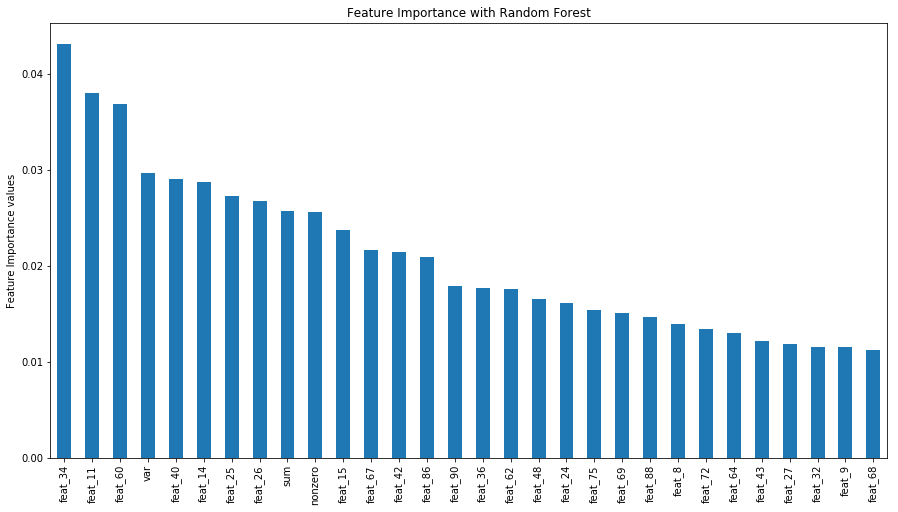

In [36]:
feat_imp[:30].plot(kind='bar', title='Feature Importance with Random Forest', figsize=(15,8))
plt.ylabel('Feature Importance values')
#plt.subplots_adjust(bottom=0.25)
#plt.savefig('FeatImportance.png')
plt.show()

In [37]:
imp_feats = list(feat_imp[:30].index)
print(imp_feats)

['feat_34', 'feat_11', 'feat_60', 'var', 'feat_40', 'feat_14', 'feat_25', 'feat_26', 'sum', 'nonzero', 'feat_15', 'feat_67', 'feat_42', 'feat_86', 'feat_90', 'feat_36', 'feat_62', 'feat_48', 'feat_24', 'feat_75', 'feat_69', 'feat_88', 'feat_8', 'feat_72', 'feat_64', 'feat_43', 'feat_27', 'feat_32', 'feat_9', 'feat_68']


### Subsetting data

In [39]:
# X = X[imp_feats]
X_train = X_train[imp_feats]
X_test = X_test[imp_feats]

# Model Training

## Pipeline (AdaBoost, RF, SVM, ET, KNN)

In [69]:
def pipeline_params():
    rf = RandomForestClassifier()
    et = ExtraTreesClassifier()
    ada = AdaBoostClassifier(base_estimator=et)
    xg = xgb.XGBClassifier(objective='multi:softprob')
    gb = GradientBoostingClassifier()
    lr = LogisticRegression()
    rfe = RFE(rf, step=0.2)
    select = SelectFromModel(rf)
    kbest = SelectKBest(chi2)
    pipe = Pipeline([('feat_sel', rfe), ('model', rf)])
    feat_sel_params = [
        {
            'feat_sel': [kbest],
            'feat_sel__k': [30]},
        {
            'feat_sel': [rfe],
            'feat_sel__estimator': [rf], #rf, et, gb, xg
            'feat_sel__n_features_to_select': [30]},
        {
            'feat_sel': [select],
            'feat_sel__estimator': [rf]} #rf, et, gb, xg
    ]
    model_params = [
        {
            'model': [gb],
            'model__n_estimators': [100], #500, 1000, 2000, 4000
            'model__learning_rate': [0.1]}, #0.01, 0.04, 0.1, 0.5, 1
#         {
#             'model': [ada],
#             'model__n_estimators': [100], #500, 1000, 2000, 4000
#             'model__learning_rate': [0.03], #0.01, 0.04, 0.1, 0.5, 1
#             'model__random_state': [9]},
        {
            'model': [xg],
            'model__objective': ['multi:softprob'],
            'model__learning_rate': [0.1],   # Learning rate alpha
            'model__gamma': [0.1],   # minimum eval_score deduction at each split
            'model__min_child_weight': [4],  # minimum number of datapoints in a split
            'model__subsample': [0.9],  # sample size row-wise during bootstrap
            'model__colsample_bytree': [0.7],  # column-wise sample size
            'model__n_estimators': [100]},   # number of trees to build
        {
            'model': [rf],
            'model__n_estimators': [100], #500, 1000, 2000, 4000
            'model__criterion': ['gini', 'entropy'],
            'model__max_features': ['sqrt'], #, 'log2'
            'model__min_samples_leaf': [4], #3, 5, 7, 9
            'model__max_depth': [11]}, #8, 10, 14
        {
            'model': [et],
            'model__n_estimators': [100], #500, 1000, 2000, 4000
            'model__criterion': ['gini', 'entropy'],
            'model__max_features': ['sqrt'], #, 'log2'
            'model__min_samples_leaf': [4], #3, 5, 7
            'model__max_depth': [11]} #8, 10, 14
    ]
    params = []
    for feat_sel in feat_sel_params:
        for model in model_params:
            # Merge dictionaries and append to list
            params.append({**feat_sel, **model})
    return pipe, feat_sel_params, model_params, params

In [70]:
pipe, feat_params, model_params, all_params = pipeline_params()

In [71]:
grid = GridSearchCV(estimator=pipe, param_grid=all_params, scoring=make_scorer(log_loss), verbose=20, n_jobs=-1)
grid.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
C:\ProgramData\Anaconda3\lib\runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
C:\ProgramData\Anaconda3\lib\runpy.py in _run_code(code=<code object <module> at 0x000002C3A07E5B70, fil...lib\site-packages\ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\ProgramData\Anaconda3\lib\site-packages\__pycache__\ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\ProgramD...a3\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x000002C3A07E5B70, fil...lib\site-packages\ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\ProgramData\Anaconda3\lib\site-packages\__pycache__\ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\ProgramD...a3\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\traitlets\config\application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    472             return self.subapp.start()
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         try:
--> 477             ioloop.IOLoop.instance().start()
    478         except KeyboardInterrupt:
    479             pass
    480 
    481 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\tornado\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'grid = GridSearchCV(estimator=pipe, param_grid=a...verbose=20, n_jobs=-1)\ngrid.fit(X_train, y_train)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 4, 9, 17, 48, 13, 248589, tzinfo=tzutc()), 'msg_id': '1D01D5827EEB479089ADAE70F0D6E4F1', 'msg_type': 'execute_request', 'session': '5C9DC171AD984C6682DEB7412202F054', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '1D01D5827EEB479089ADAE70F0D6E4F1', 'msg_type': 'execute_request', 'parent_header': {}})
    230             self.log.warn("Unknown message type: %r", msg_type)
    231         else:
    232             self.log.debug("%s: %s", msg_type, msg)
    233             self.pre_handler_hook()
    234             try:
--> 235                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'5C9DC171AD984C6682DEB7412202F054']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'grid = GridSearchCV(estimator=pipe, param_grid=a...verbose=20, n_jobs=-1)\ngrid.fit(X_train, y_train)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 4, 9, 17, 48, 13, 248589, tzinfo=tzutc()), 'msg_id': '1D01D5827EEB479089ADAE70F0D6E4F1', 'msg_type': 'execute_request', 'session': '5C9DC171AD984C6682DEB7412202F054', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '1D01D5827EEB479089ADAE70F0D6E4F1', 'msg_type': 'execute_request', 'parent_header': {}}
    236             except Exception:
    237                 self.log.error("Exception in message handler:", exc_info=True)
    238             finally:
    239                 self.post_handler_hook()

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'5C9DC171AD984C6682DEB7412202F054'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'grid = GridSearchCV(estimator=pipe, param_grid=a...verbose=20, n_jobs=-1)\ngrid.fit(X_train, y_train)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 4, 9, 17, 48, 13, 248589, tzinfo=tzutc()), 'msg_id': '1D01D5827EEB479089ADAE70F0D6E4F1', 'msg_type': 'execute_request', 'session': '5C9DC171AD984C6682DEB7412202F054', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '1D01D5827EEB479089ADAE70F0D6E4F1', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='grid = GridSearchCV(estimator=pipe, param_grid=a...verbose=20, n_jobs=-1)\ngrid.fit(X_train, y_train)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'grid = GridSearchCV(estimator=pipe, param_grid=a...verbose=20, n_jobs=-1)\ngrid.fit(X_train, y_train)'
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('grid = GridSearchCV(estimator=pipe, param_grid=a...verbose=20, n_jobs=-1)\ngrid.fit(X_train, y_train)',), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('grid = GridSearchCV(estimator=pipe, param_grid=a...verbose=20, n_jobs=-1)\ngrid.fit(X_train, y_train)',)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='grid = GridSearchCV(estimator=pipe, param_grid=a...verbose=20, n_jobs=-1)\ngrid.fit(X_train, y_train)', store_history=True, silent=False, shell_futures=True)
   2693                 self.displayhook.exec_result = result
   2694 
   2695                 # Execute the user code
   2696                 interactivity = "none" if silent else self.ast_node_interactivity
   2697                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2698                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2699                 
   2700                 self.last_execution_succeeded = not has_raised
   2701 
   2702                 # Reset this so later displayed values do not modify the

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Expr object>], cell_name='<ipython-input-71-5ddff90266fd>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 2c3b46880f0, executio..._before_exec=None error_in_exec=None result=None>)
   2803                     return True
   2804 
   2805             for i, node in enumerate(to_run_interactive):
   2806                 mod = ast.Interactive([node])
   2807                 code = compiler(mod, cell_name, "single")
-> 2808                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x000002C3A8032420, file "<ipython-input-71-5ddff90266fd>", line 2>
        result = <ExecutionResult object at 2c3b46880f0, executio..._before_exec=None error_in_exec=None result=None>
   2809                     return True
   2810 
   2811             # Flush softspace
   2812             if softspace(sys.stdout, 0):

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x000002C3A8032420, file "<ipython-input-71-5ddff90266fd>", line 2>, result=<ExecutionResult object at 2c3b46880f0, executio..._before_exec=None error_in_exec=None result=None>)
   2857         outflag = True  # happens in more places, so it's easier as default
   2858         try:
   2859             try:
   2860                 self.hooks.pre_run_code_hook()
   2861                 #rprint('Running code', repr(code_obj)) # dbg
-> 2862                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x000002C3A8032420, file "<ipython-input-71-5ddff90266fd>", line 2>
        self.user_global_ns = {'AdaBoostClassifier': <class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'>, 'DataFrame': <class 'pandas.core.frame.DataFrame'>, 'ExtraTreesClassifier': <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>, 'GaussianNB': <class 'sklearn.naive_bayes.GaussianNB'>, 'GradientBoostingClassifier': <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', "get_ipython().magic('matplotlib inline')\nfrom pa...ction import SelectFpr, chi2, mutual_info_classif", 'from warnings import simplefilter\nsimplefilter("ignore")', '# Train data\ndata = read_csv("train.csv")\n\n# Test data\ntest = read_csv("test.csv")', 'data.head(2)', 'data[\'target\'] = data[\'target\'].apply(lambda x: ...p the "ID" column\ntrain = data.drop(\'id\', axis=1)', "X = train.loc[:, :'feat_93']\ny = train['target']\nprint(X.head(2))", r"print('Target Class\n', train['target'].value_counts())", '# Missing value check\nX_train.isnull().sum()', '# Splitting Train test\nX_train, X_test, y_train,...X, y, stratify=y, test_size=0.3, random_state=12)', 'y_test.head(2)', '# Missing value check\nX_train.isnull().sum()', 'from numpy import var, count_nonzero\n\ndef agg_fe...ount_nonzero(row.values), axis=1)\n    return data', '# Train data\ndata = read_csv("train.csv")\n\n# Tes...test.csv")\ntest = test.loc[:, \'feat_1\':\'feat_93\']', 'data[\'target\'] = data[\'target\'].apply(lambda x: ...p the "ID" column\ntrain = data.drop(\'id\', axis=1)', "X = train.loc[:, :'feat_93']\ny = train['target']\nprint(X.head(2))", '# Normalization of Train and Test\ncols = list(X....\ntest_xgb_org.columns = cols\ntest_xgb_org.head(2)', "get_ipython().magic('matplotlib inline')\nfrom pa...ction import SelectFpr, chi2, mutual_info_classif", 'from warnings import simplefilter\nsimplefilter("ignore")', '# Train data\ndata = read_csv("train.csv")\n\n# Tes...test.csv")\ntest = test.loc[:, \'feat_1\':\'feat_93\']', ...], 'KNeighborsClassifier': <class 'sklearn.neighbors.classification.KNeighborsClassifier'>, 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'Out': {4:    id  feat_1  feat_2  feat_3  feat_4  feat_5  f...     0        0  Class_1  

[2 rows x 95 columns], 10: 26781    4
44888    6
Name: target, dtype: int64, 11: feat_1     0
feat_2     0
feat_3     0
feat_4   ...eat_92    0
feat_93    0
Length: 93, dtype: int64, 20:    id  feat_1  feat_2  feat_3  feat_4  feat_5  f...     0        0  Class_1  

[2 rows x 95 columns], 24: 26781    4
44888    6
Name: target, dtype: int64, 26: feat_1     0
feat_2     0
feat_3     0
feat_4   ...eat_92    0
feat_93    0
Length: 93, dtype: int64, 29:    feat_1  feat_2  feat_3  feat_4  feat_5  feat_...120  160.800362       24  

[2 rows x 96 columns], 34: RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), 44: array([3, 6, 4, 2, 1, 7, 5, 8, 9], dtype=int64), 52:    id  feat_1  feat_2  feat_3  feat_4  feat_5  f...     0        0  Class_1  

[2 rows x 95 columns], ...}, ...}
        self.user_ns = {'AdaBoostClassifier': <class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'>, 'DataFrame': <class 'pandas.core.frame.DataFrame'>, 'ExtraTreesClassifier': <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>, 'GaussianNB': <class 'sklearn.naive_bayes.GaussianNB'>, 'GradientBoostingClassifier': <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', "get_ipython().magic('matplotlib inline')\nfrom pa...ction import SelectFpr, chi2, mutual_info_classif", 'from warnings import simplefilter\nsimplefilter("ignore")', '# Train data\ndata = read_csv("train.csv")\n\n# Test data\ntest = read_csv("test.csv")', 'data.head(2)', 'data[\'target\'] = data[\'target\'].apply(lambda x: ...p the "ID" column\ntrain = data.drop(\'id\', axis=1)', "X = train.loc[:, :'feat_93']\ny = train['target']\nprint(X.head(2))", r"print('Target Class\n', train['target'].value_counts())", '# Missing value check\nX_train.isnull().sum()', '# Splitting Train test\nX_train, X_test, y_train,...X, y, stratify=y, test_size=0.3, random_state=12)', 'y_test.head(2)', '# Missing value check\nX_train.isnull().sum()', 'from numpy import var, count_nonzero\n\ndef agg_fe...ount_nonzero(row.values), axis=1)\n    return data', '# Train data\ndata = read_csv("train.csv")\n\n# Tes...test.csv")\ntest = test.loc[:, \'feat_1\':\'feat_93\']', 'data[\'target\'] = data[\'target\'].apply(lambda x: ...p the "ID" column\ntrain = data.drop(\'id\', axis=1)', "X = train.loc[:, :'feat_93']\ny = train['target']\nprint(X.head(2))", '# Normalization of Train and Test\ncols = list(X....\ntest_xgb_org.columns = cols\ntest_xgb_org.head(2)', "get_ipython().magic('matplotlib inline')\nfrom pa...ction import SelectFpr, chi2, mutual_info_classif", 'from warnings import simplefilter\nsimplefilter("ignore")', '# Train data\ndata = read_csv("train.csv")\n\n# Tes...test.csv")\ntest = test.loc[:, \'feat_1\':\'feat_93\']', ...], 'KNeighborsClassifier': <class 'sklearn.neighbors.classification.KNeighborsClassifier'>, 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'Out': {4:    id  feat_1  feat_2  feat_3  feat_4  feat_5  f...     0        0  Class_1  

[2 rows x 95 columns], 10: 26781    4
44888    6
Name: target, dtype: int64, 11: feat_1     0
feat_2     0
feat_3     0
feat_4   ...eat_92    0
feat_93    0
Length: 93, dtype: int64, 20:    id  feat_1  feat_2  feat_3  feat_4  feat_5  f...     0        0  Class_1  

[2 rows x 95 columns], 24: 26781    4
44888    6
Name: target, dtype: int64, 26: feat_1     0
feat_2     0
feat_3     0
feat_4   ...eat_92    0
feat_93    0
Length: 93, dtype: int64, 29:    feat_1  feat_2  feat_3  feat_4  feat_5  feat_...120  160.800362       24  

[2 rows x 96 columns], 34: RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), 44: array([3, 6, 4, 2, 1, 7, 5, 8, 9], dtype=int64), 52:    id  feat_1  feat_2  feat_3  feat_4  feat_5  f...     0        0  Class_1  

[2 rows x 95 columns], ...}, ...}
   2863             finally:
   2864                 # Reset our crash handler in place
   2865                 sys.excepthook = old_excepthook
   2866         except SystemExit as e:

...........................................................................
C:\Users\nikhi\Desktop\Practice\Kaggle-Otto\<ipython-input-71-5ddff90266fd> in <module>()
      1 grid = GridSearchCV(estimator=pipe, param_grid=all_params, scoring=make_scorer(log_loss), verbose=20, n_jobs=-1)
----> 2 grid.fit(X_train, y_train)

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py in fit(self=GridSearchCV(cv=None, error_score='raise',
     ...       scoring=make_scorer(log_loss), verbose=20), X=       feat_1  feat_2  feat_3  feat_4  feat_5  f...   3.203259        8  

[43314 rows x 96 columns], y=24063    3
33236    6
27133    4
11702    2
2867...18    3
Name: target, Length: 43314, dtype: int64, groups=None, **fit_params={})
    634                                   return_train_score=self.return_train_score,
    635                                   return_n_test_samples=True,
    636                                   return_times=True, return_parameters=False,
    637                                   error_score=self.error_score)
    638           for parameters, (train, test) in product(candidate_params,
--> 639                                                    cv.split(X, y, groups)))
        cv.split = <bound method StratifiedKFold.split of Stratifie...ld(n_splits=3, random_state=None, shuffle=False)>
        X =        feat_1  feat_2  feat_3  feat_4  feat_5  f...   3.203259        8  

[43314 rows x 96 columns]
        y = 24063    3
33236    6
27133    4
11702    2
2867...18    3
Name: target, Length: 43314, dtype: int64
        groups = None
    640 
    641         # if one choose to see train score, "out" will contain train score info
    642         if self.return_train_score:
    643             (train_score_dicts, test_score_dicts, test_sample_counts, fit_time,

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseSearchCV.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Mon Apr  9 23:20:04 2018
PID: 11184                Python 3.6.3: C:\ProgramData\Anaconda3\python.exe
...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (Pipeline(memory=None,
     steps=[('feat_sel', S....0, verbose=0,
              warm_start=False))]),        feat_1  feat_2  feat_3  feat_4  feat_5  f...   3.203259        8  

[43314 rows x 96 columns], 24063    3
33236    6
27133    4
11702    2
2867...18    3
Name: target, Length: 43314, dtype: int64, {'score': make_scorer(log_loss)}, array([14090, 14097, 14160, ..., 43311, 43312, 43313]), array([    0,     1,     2, ..., 14606, 14609, 14616]), 20, {'feat_sel': SelectKBest(k=30, score_func=<function chi2 at 0x00000282DDA20400>), 'feat_sel__k': 30, 'model': GradientBoostingClassifier(criterion='friedman_m...e=1.0, verbose=0,
              warm_start=False), 'model__learning_rate': 0.1, 'model__n_estimators': 100}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (Pipeline(memory=None,
     steps=[('feat_sel', S....0, verbose=0,
              warm_start=False))]),        feat_1  feat_2  feat_3  feat_4  feat_5  f...   3.203259        8  

[43314 rows x 96 columns], 24063    3
33236    6
27133    4
11702    2
2867...18    3
Name: target, Length: 43314, dtype: int64, {'score': make_scorer(log_loss)}, array([14090, 14097, 14160, ..., 43311, 43312, 43313]), array([    0,     1,     2, ..., 14606, 14609, 14616]), 20, {'feat_sel': SelectKBest(k=30, score_func=<function chi2 at 0x00000282DDA20400>), 'feat_sel__k': 30, 'model': GradientBoostingClassifier(criterion='friedman_m...e=1.0, verbose=0,
              warm_start=False), 'model__learning_rate': 0.1, 'model__n_estimators': 100})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py in _fit_and_score(estimator=Pipeline(memory=None,
     steps=[('feat_sel', S....0, verbose=0,
              warm_start=False))]), X=       feat_1  feat_2  feat_3  feat_4  feat_5  f...   3.203259        8  

[43314 rows x 96 columns], y=24063    3
33236    6
27133    4
11702    2
2867...18    3
Name: target, Length: 43314, dtype: int64, scorer={'score': make_scorer(log_loss)}, train=array([14090, 14097, 14160, ..., 43311, 43312, 43313]), test=array([    0,     1,     2, ..., 14606, 14609, 14616]), verbose=20, parameters={'feat_sel': SelectKBest(k=30, score_func=<function chi2 at 0x00000282DDA20400>), 'feat_sel__k': 30, 'model': GradientBoostingClassifier(criterion='friedman_m...e=1.0, verbose=0,
              warm_start=False), 'model__learning_rate': 0.1, 'model__n_estimators': 100}, fit_params={}, return_train_score='warn', return_parameters=False, return_n_test_samples=True, return_times=True, error_score='raise')
    483                              " make sure that it has been spelled correctly.)")
    484 
    485     else:
    486         fit_time = time.time() - start_time
    487         # _score will return dict if is_multimetric is True
--> 488         test_scores = _score(estimator, X_test, y_test, scorer, is_multimetric)
        test_scores = {}
        estimator = Pipeline(memory=None,
     steps=[('feat_sel', S....0, verbose=0,
              warm_start=False))])
        X_test =        feat_1  feat_2  feat_3  feat_4  feat_5  f...  12.493889       11  

[14440 rows x 96 columns]
        y_test = 24063    3
33236    6
27133    4
11702    2
2867...78    3
Name: target, Length: 14440, dtype: int64
        scorer = {'score': make_scorer(log_loss)}
        is_multimetric = True
    489         score_time = time.time() - start_time - fit_time
    490         if return_train_score:
    491             train_scores = _score(estimator, X_train, y_train, scorer,
    492                                   is_multimetric)

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py in _score(estimator=Pipeline(memory=None,
     steps=[('feat_sel', S....0, verbose=0,
              warm_start=False))]), X_test=       feat_1  feat_2  feat_3  feat_4  feat_5  f...  12.493889       11  

[14440 rows x 96 columns], y_test=24063    3
33236    6
27133    4
11702    2
2867...78    3
Name: target, Length: 14440, dtype: int64, scorer={'score': make_scorer(log_loss)}, is_multimetric=True)
    518 
    519     Will return a single float if is_multimetric is False and a dict of floats,
    520     if is_multimetric is True
    521     """
    522     if is_multimetric:
--> 523         return _multimetric_score(estimator, X_test, y_test, scorer)
        estimator = Pipeline(memory=None,
     steps=[('feat_sel', S....0, verbose=0,
              warm_start=False))])
        X_test =        feat_1  feat_2  feat_3  feat_4  feat_5  f...  12.493889       11  

[14440 rows x 96 columns]
        y_test = 24063    3
33236    6
27133    4
11702    2
2867...78    3
Name: target, Length: 14440, dtype: int64
        scorer = {'score': make_scorer(log_loss)}
    524     else:
    525         if y_test is None:
    526             score = scorer(estimator, X_test)
    527         else:

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py in _multimetric_score(estimator=Pipeline(memory=None,
     steps=[('feat_sel', S....0, verbose=0,
              warm_start=False))]), X_test=       feat_1  feat_2  feat_3  feat_4  feat_5  f...  12.493889       11  

[14440 rows x 96 columns], y_test=24063    3
33236    6
27133    4
11702    2
2867...78    3
Name: target, Length: 14440, dtype: int64, scorers={'score': make_scorer(log_loss)})
    548 
    549     for name, scorer in scorers.items():
    550         if y_test is None:
    551             score = scorer(estimator, X_test)
    552         else:
--> 553             score = scorer(estimator, X_test, y_test)
        score = undefined
        scorer = make_scorer(log_loss)
        estimator = Pipeline(memory=None,
     steps=[('feat_sel', S....0, verbose=0,
              warm_start=False))])
        X_test =        feat_1  feat_2  feat_3  feat_4  feat_5  f...  12.493889       11  

[14440 rows x 96 columns]
        y_test = 24063    3
33236    6
27133    4
11702    2
2867...78    3
Name: target, Length: 14440, dtype: int64
    554 
    555         if hasattr(score, 'item'):
    556             try:
    557                 # e.g. unwrap memmapped scalars

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py in __call__(self=make_scorer(log_loss), estimator=Pipeline(memory=None,
     steps=[('feat_sel', S....0, verbose=0,
              warm_start=False))]), X=       feat_1  feat_2  feat_3  feat_4  feat_5  f...  12.493889       11  

[14440 rows x 96 columns], y_true=24063    3
33236    6
27133    4
11702    2
2867...78    3
Name: target, Length: 14440, dtype: int64, sample_weight=None)
    103             return self._sign * self._score_func(y_true, y_pred,
    104                                                  sample_weight=sample_weight,
    105                                                  **self._kwargs)
    106         else:
    107             return self._sign * self._score_func(y_true, y_pred,
--> 108                                                  **self._kwargs)
        self._kwargs = {}
    109 
    110 
    111 class _ProbaScorer(_BaseScorer):
    112     def __call__(self, clf, X, y, sample_weight=None):

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py in log_loss(y_true=24063    3
33236    6
27133    4
11702    2
2867...78    3
Name: target, Length: 14440, dtype: int64, y_pred=array([[  9.99200722e-16,   1.00000000e+00],
   ...0],
       [  9.99200722e-16,   1.00000000e+00]]), eps=1e-15, normalize=True, sample_weight=None, labels=None)
   1681                              "classes {0}, {1}. Please provide the true "
   1682                              "labels explicitly through the labels argument. "
   1683                              "Classes found in "
   1684                              "y_true: {2}".format(transformed_labels.shape[1],
   1685                                                   y_pred.shape[1],
-> 1686                                                   lb.classes_))
        lb.classes_ = array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)
   1687         else:
   1688             raise ValueError('The number of classes in labels is different '
   1689                              'from that in y_pred. Classes found in '
   1690                              'labels: {0}'.format(lb.classes_))

ValueError: y_true and y_pred contain different number of classes 9, 2. Please provide the true labels explicitly through the labels argument. Classes found in y_true: [1 2 3 4 5 6 7 8 9]
___________________________________________________________________________

In [ ]:
# CV results
cv_result_pipe = DataFrame(grid.cv_results_).sort_values('rank_test_score').to_csv('cv_result_pipe.csv', index=False)
print(grid.best_score_)
print(grid.best_estimator_)

In [ ]:
imp_feats = X_train.columns.values[grid.best_params_['feat_sel'].get_support(indices=True)]
print(imp_feats)

In [ ]:
best_model = grid.best_estimator_.fit(X_train[imp_feats], y_train)
y_pred = best_model.predict(X_test[imp_feats])
# print(y_pred[:4])

print('MCC:', matthews_corrcoef(y_test, y_pred))
print('Acc:', accuracy_score(y_test, y_pred))
print('Confusion Matrix\n', confusion_matrix(y_test, y_pred))

### XGBoost

In [ ]:
import xgboost as xgb

# Doing gridsearch to find best params configuration
clf = xgb.XGBClassifier(objective='multi:softprob', eval_metric='mlogloss')

params = {
    'learning_rate': [0.02],   # Learning rate alpha
    'max_depth': [10],   # maximum depth of the tree
    'gamma': [1],   # minimum eval_score deduction at each split
    'min_child_weight': [6],  # minimum number of datapoints in a split
    'subsample': [0.9],  # sample size row-wise during bootstrap
    'colsample_bytree': [0.4],  # column-wise sample size
    'n_estimators': [1000],   # number of trees to build
    }

grid = GridSearchCV(clf, params, cv=5, verbose=20, n_jobs=-1, refit=True)

grid.fit(X_train, y_train)

# CV results
cv_result = DataFrame(grid.cv_results_).to_csv('cv_results.csv', index=False)

In [ ]:
print(grid.best_score_)
print(grid.best_estimator_)

In [ ]:
# Testing on X_test
pred = grid.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred))
print('MCC:', matthews_corrcoef(y_test, pred))

In [ ]:
# Using best params to find optimum number of iterations
grid_output = grid.best_params_
params = {
    'objective': 'multi:softprob', 
    'eval_metric': 'mlogloss', 
    'num_class': 9
    }

best_params = {**grid_output, **params}
#best_params['learning_rate'] = 0.02
#print(best_params)

In [ ]:
train_xgb = xgb.DMatrix(X_train, y_train)

cv_results = xgb.cv(best_params, train_xgb, num_boost_round=10000, nfold=5, stratified=True, as_pandas=True, 
                    seed=1, shuffle=True, early_stopping_rounds=20, verbose_eval=True)

In [ ]:
nround = cv_results.shape[0]  # Where the best iteration happened
print('Best Iteration:', nround)
xgb_clf = xgb.train(best_params, train_xgb, num_boost_round=nround, verbose_eval=True)

# Predicting on the test set
test_xgb  = xgb.DMatrix(test_xgb_org)
test_pred = xgb_clf.predict(test_xgb)
Class_1, Class_2, Class_3, Class_4, Class_5, Class_6, Class_7, Class_8, Class_9 = map(list, zip(*test_pred))
output = DataFrame({'id': test['id'],
                    'Class_1': Class_1, 
                    'Class_2': Class_2, 
                    'Class_3': Class_3, 
                    'Class_4': Class_4, 
                    'Class_5': Class_5, 
                    'Class_6': Class_6, 
                    'Class_7': Class_7, 
                    'Class_8': Class_8, 
                    'Class_9': Class_9})
output = output[['id', 'Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6', 'Class_7', 'Class_8', 'Class_9']]

output.to_csv('output.csv', index=False)
output.head(2)